In [36]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir(r'C:\Users\Ram\Ram DS Projects\Linear Regression')
house_info= pd.read_csv('raw house data cleaned.csv')

In [ ]:
house_info

In [38]:
house_info.columns=[cols.lower() for cols in house_info.columns]
house_info.columns

Index(['mls', 'sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres',
       'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage',
       'kitchen_features', 'fireplaces', 'floor_covering', 'hoa'],
      dtype='object')

# List of columns for which we want to remove outliers

In [39]:
columns_to_filter = [
    'mls', 'sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres', 
    'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage', 
    'kitchen_features', 'fireplaces', 'floor_covering', 'hoa'
]

# Compute Q1, Q3, and IQR for each column
Q1 = house_info[columns_to_filter].quantile(0.25)
Q3 = house_info[columns_to_filter].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
house_info_cleaned = house_info[
    ~((house_info[columns_to_filter] < lower_bound) | 
      (house_info[columns_to_filter] > upper_bound)).any(axis=1)
]

In [40]:
print(f"Original dataset size: {house_info.shape}")
print(f"Cleaned dataset size: {house_info_cleaned.shape}")

Original dataset size: (5000, 16)
Cleaned dataset size: (3166, 16)


In [41]:
house_info_cleaned['fireplaces'].value_counts()

fireplaces
1    1240
2    1057
3     495
0     204
4     145
5      25
Name: count, dtype: int64

# Manual Train-Test Split (No Libraries)

In [42]:

features = ['sold_price', 'zipcode', 'sqrt_ft', 'lot_acres', 'year_built', 
            'bedrooms', 'bathrooms', 'garage']
target = 'fireplaces'

# Convert to numpy arrays
X = house_info_cleaned[features].values
y = house_info_cleaned[target].values

# Shuffle the data
N = len(X)
indices = np.arange(N)
np.random.seed(42)  # for reproducibility
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

# 80-20 split
split_point = int(0.8 * N)
X_train = X[:split_point]
y_train = y[:split_point]
X_test = X[split_point:]
y_test = y[split_point:]


In [ ]:
print('xtrain',X_train,'ytrain',y_train,'xtest',X_test,'ytest',y_test)

In [43]:
# Compute mean and std from training set
mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-8  # avoid divide by zero

# Standardize train and test
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std


In [73]:
class KNNRegressor():
    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X, K=5, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)
        for i in range(N):
            dist2 = np.sum((self.X - X[i]) ** 2, axis=1)
            idxt = np.argsort(dist2)[:K]
            gamma_k = np.exp(-dist2[idxt]) / (np.exp(-dist2[idxt]).sum() + epsilon)
            y_hat[i] = gamma_k.dot(self.y[idxt])
        return y_hat

class KNNCLassifier():
  def fit(self,X,y):
    self.X=X
    self.y=y

  def predict(self, X, K, epsilon= 1e-3):
    N= len(X)
    y_hat=np.zeros(N)

    for i in range(N):
      dist2 = np.sum((self.X-X[i])**2,axis=1)
      idxt=np.argsort(dist2)[:K]
      gamma_k=1/(np.sqrt(dist2[idxt]+epsilon))

      y_hat[i]=np.bincount(self.y[idxt],weights=gamma_k).argmax()

    return y_hat


class MVLinearRegression():
    def fit(self, X, y, eta=1e-3, epochs=1000, show_curve=True):
        N, D = X.shape
        self.W = np.random.randn(D)
        self.J = np.zeros(epochs)
        for epoch in range(epochs):
            Y_hat = self.predict(X)
            self.J[epoch] = OLS(y, Y_hat, N)
            self.W -= eta * (1 / N) * (X.T @ (Y_hat - y))
        if show_curve:
            plt.plot(self.J)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Training Curve")
            plt.show()

    def predict(self, X):
        return X @ self.W


def MAE(Y, Y_hat):
    return np.mean(np.abs(Y - Y_hat))

def R2(Y, Y_hat):
    return 1 - (np.sum((Y - Y_hat) ** 2) / np.sum((Y - np.mean(Y)) ** 2))

def OLS(Y, Y_hat, N):
    return (1 / (2 * N)) * np.sum((Y - Y_hat) ** 2)


In [81]:
knn = KNNRegressor()
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled, K=5)
y_pred_knn_rounded = np.round(y_pred_knn).astype(int)
print(y_pred_knn_rounded)

[1 1 1 1 3 1 2 2 2 1 3 2 1 0 2 2 2 2 2 2 1 1 2 2 1 2 2 4 2 2 2 3 1 2 2 1 1
 1 2 2 2 1 3 1 2 1 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 3 2 2 2 2 2 2
 1 3 1 2 2 3 2 2 2 2 3 1 2 2 3 1 1 1 1 1 2 2 3 1 2 1 2 1 1 2 2 2 2 2 1 1 2
 2 1 1 2 2 1 3 3 2 2 2 1 1 2 1 1 1 3 1 2 2 1 2 2 2 0 1 2 2 3 1 2 1 2 4 2 1
 1 2 2 2 2 2 1 3 2 1 1 2 1 2 1 2 2 2 2 2 2 3 2 2 2 2 2 1 1 2 2 2 3 1 2 2 2
 2 3 2 1 1 2 1 2 2 2 2 1 2 0 2 1 3 1 2 1 2 1 2 2 2 2 1 2 4 2 3 2 2 1 2 3 1
 2 2 1 2 2 2 3 2 1 4 2 2 3 2 2 2 2 2 2 2 1 2 4 3 3 2 2 1 1 1 1 3 1 1 2 2 3
 1 2 1 2 1 0 1 2 2 1 1 1 3 1 2 1 1 3 2 2 1 3 2 2 2 1 2 1 2 2 2 1 2 1 3 1 3
 1 0 1 2 1 2 2 2 3 1 2 2 1 1 1 2 3 2 2 2 2 2 1 2 1 2 3 2 1 1 1 1 2 3 2 2 1
 2 2 2 0 3 1 1 3 2 1 3 1 2 2 2 1 0 1 2 2 1 2 1 0 2 1 3 2 3 1 2 1 1 1 3 1 2
 1 1 1 2 2 2 1 2 2 2 2 1 3 3 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 3 1 2 2 2 2 2 3
 2 2 1 2 1 2 1 2 1 1 2 1 3 1 1 3 2 2 0 2 2 1 1 2 2 2 1 1 2 1 2 3 2 1 2 3 2
 2 2 2 2 1 1 2 2 1 2 1 1 2 4 1 1 1 2 2 2 1 1 1 1 2 1 2 1 2 2 1 2 0 2 2 1 2
 2 3 1 3 2 2 1 2 2 2 2 0 

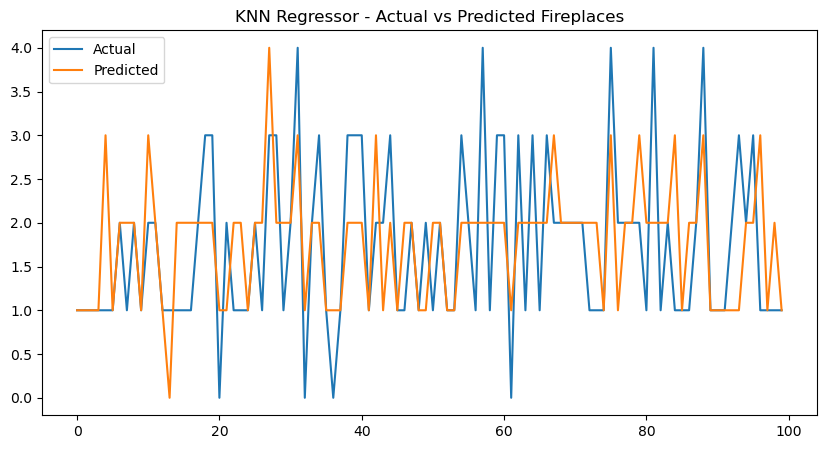

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred_knn_rounded[:100], label='Predicted')
plt.title("KNN Regressor - Actual vs Predicted Fireplaces")
plt.legend()
plt.show()


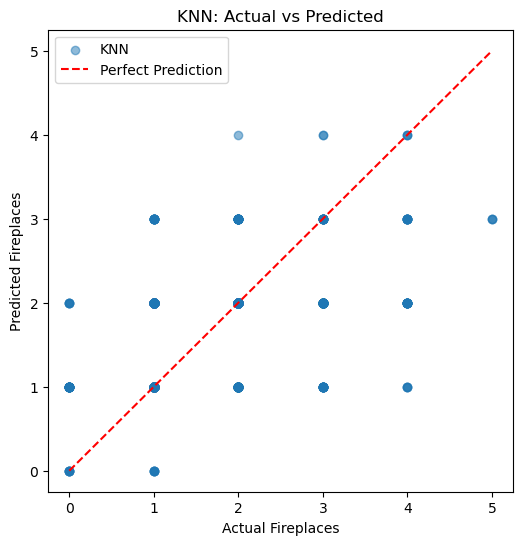

In [112]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_knn_rounded, alpha=0.5, label='KNN')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Fireplaces")
plt.ylabel("Predicted Fireplaces")
plt.title("KNN: Actual vs Predicted")
plt.legend()

plt.show()


In [84]:
print("Evaluation Metrics")
print("KNN MAE:", mae_knn)
print("KNN R² :", r2_knn)

Evaluation Metrics
KNN MAE: 0.6985513396297445
KNN R² : 0.20847515443139175


# --- Train and Predict with MVLinearRegression ---

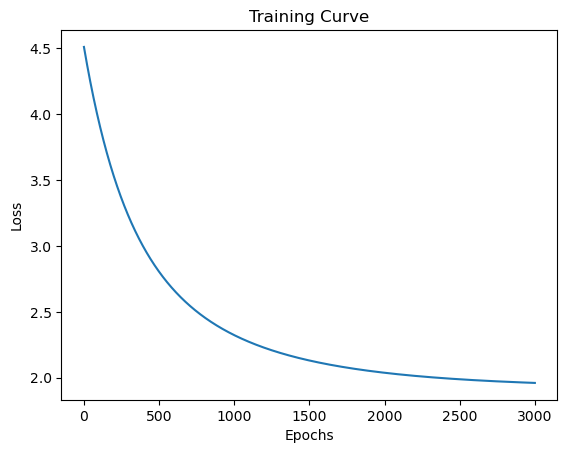

In [89]:
linreg = MVLinearRegression()
linreg.fit(X_train_scaled, y_train, eta=1e-3, epochs=3000)
y_pred_lin = linreg.predict(X_test_scaled)
y_pred_lin_rounded = np.clip(np.round(y_pred_lin), 0, 5).astype(int)

In [90]:
print("Linear MAE:", MAE(y_test, y_pred_lin_rounded))
print("Linear R² :", R2(y_test, y_pred_lin_rounded))

Linear MAE: 1.6198738170347002
Linear R² : -2.583115996658449


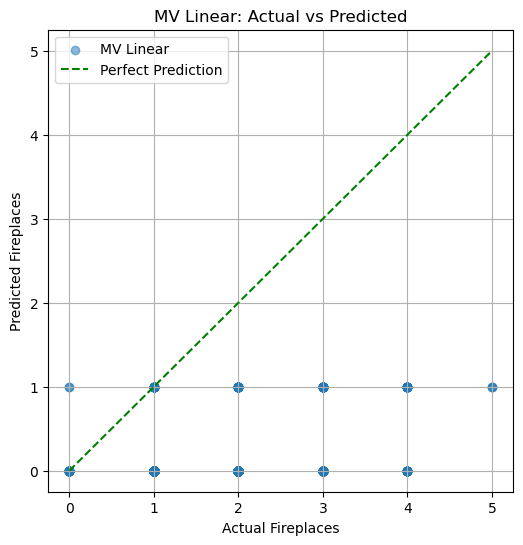

In [91]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lin_rounded, alpha=0.5, label='MV Linear')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--', label='Perfect Prediction')
plt.xlabel("Actual Fireplaces")
plt.ylabel("Predicted Fireplaces")
plt.title("MV Linear: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


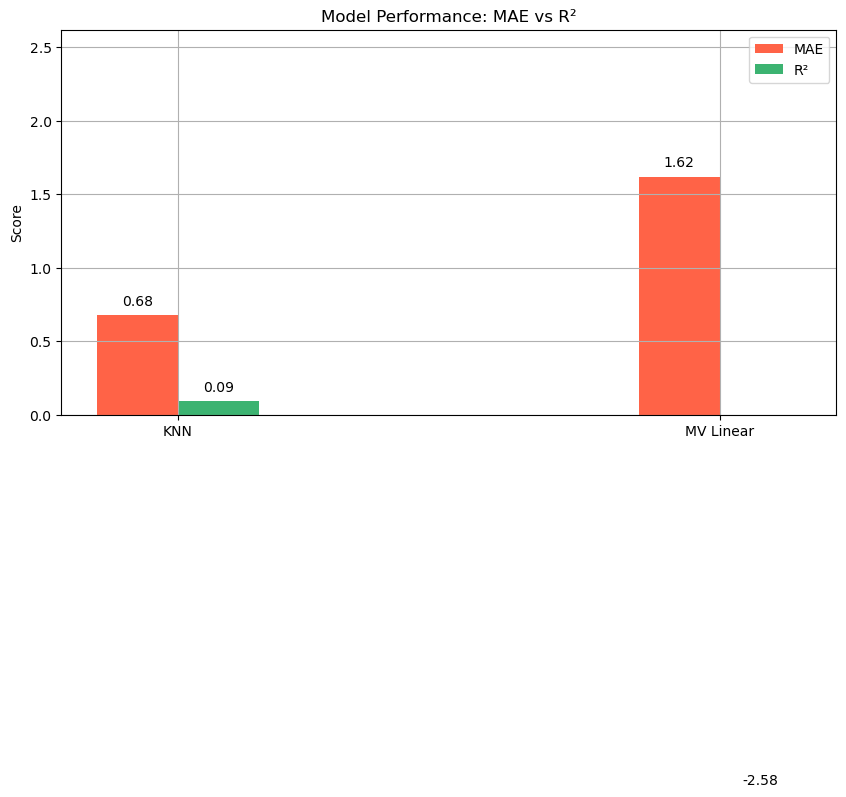

In [113]:
# Compute metrics
mae_knn = MAE(y_test, y_pred_knn_rounded)
mae_lin = MAE(y_test, y_pred_lin_rounded)
r2_knn = R2(y_test, y_pred_knn_rounded)
r2_lin = R2(y_test, y_pred_lin_rounded)

# Bar chart
labels = ['KNN', 'MV Linear']
maes = [mae_knn, mae_lin]
r2s = [r2_knn, r2_lin]

x = np.arange(len(labels))  
width = 0.15 

plt.figure(figsize=(10, 5))
# MAE Bars
bars_mae = plt.bar(x - width/2, maes, width, label='MAE', color='tomato')
# R2 Bars
bars_r2 = plt.bar(x + width/2, r2s, width, label='R²', color='mediumseagreen')

# Add value labels on top
for bar in bars_mae:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

for bar in bars_r2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

# Final plot settings
plt.ylabel('Score')
plt.title('Model Performance: MAE vs R²')
plt.xticks(x, labels)
plt.ylim(0, max(max(maes), max(r2s)) + 1)
plt.legend()
plt.grid(True)
plt.show()


# Function to predict fireplaces

In [108]:

def predict_fireplaces(input_array, mean, std, knn_model, mv_linear_model, K=5):
    # Step 1: Standardize input
    x_input_scaled = (input_array - mean) / std
    x_input_scaled = x_input_scaled.reshape(1, -1)

    # Step 2: Predict
    pred_knn = knn_model.predict(x_input_scaled, K=K)[0]
    pred_lin = mv_linear_model.predict(x_input_scaled)[0]

    # Step 3: Round & clip to valid range [0, 5]
    pred_knn_rounded = int(np.clip(round(pred_knn), 0, 5))
    pred_lin_rounded = int(np.clip(round(pred_lin), 0, 5))

    # Step 4: Output
    print("Input Values:", input_array)
    print("Predicted fireplaces using KNN Regressor:", pred_knn_rounded)
    print("Predicted fireplaces using MV Linear Regression:", pred_lin_rounded)

    return pred_knn_rounded, pred_lin_rounded


In [121]:
# features = ['sold_price', 'zipcode', 'sqrt_ft', 'lot_acres', 'year_built', 
            # 'bedrooms', 'bathrooms', 'garage']

input_values = np.array([10000, 85700, 1500, 1.25, 1986, 2, 2, 1])

# Run prediction
predict_fireplaces(
    input_array=input_values,
    mean=mean,
    std=std,
    knn_model=knn,
    mv_linear_model=linreg,
    K=5
)

Input Values: [1.000e+04 8.570e+04 1.500e+03 1.250e+00 1.986e+03 2.000e+00 2.000e+00
 1.000e+00]
Predicted fireplaces using KNN Regressor: 0
Predicted fireplaces using MV Linear Regression: 0


(0, 0)